In [366]:
import torch as tr
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [367]:
device = tr.device('cuda' if tr.cuda.is_available() else 'cpu')
# print(device)

In [368]:
def d(L,a=1):
    direction_mapping = [
        tr.tensor([0,1],dtype=tr.float).to(device), #up
        tr.tensor([0,-1],dtype=tr.float).to(device),#down
        tr.tensor([-1,0],dtype=tr.float).to(device), #left
        tr.tensor([1,0],dtype=tr.float).to(device) #right
    ]

    return tr.stack(direction_mapping).to(device)[L]*a

def custom_loss(output,target):
    return tr((output-target)**2).mean()

In [369]:
#Agent Class
class Agent(nn.Module):
    def __init__(self, x, y):#initialize agent at location (-0.5,-0.5) with bias 0
        super(Agent, self).__init__()
        self.x=x #x coordinate
        self.y=y #y coordinate
        self.input = nn.Linear(4, 64,dtype=tr.float) #input layer
        self.hidden1 = nn.Linear(64, 64,dtype=tr.float) #hidden layer
        self.hidden2 = nn.Linear(64, 32, dtype = tr.float) #hidden layer
        self.output = nn.Linear(32, 4,dtype=tr.float) #output layer
        self.activation = nn.LeakyReLU() #activation function

    def forward(self, x): #forward pass
        x1 = self.activation(self.input(x))
        x2 = self.activation(self.hidden1(x1))
        x3 = self.activation(self.hidden2(x2))
        x4 = self.activation(self.output(x3))
        return x4
    

    def move(self,Q,e):
        # E=tr.ones(Q.shape[0]).to(device)
        # E*=e
        # if tr.rand(size=(Q.shape[0])).to(device) < E: #epsilon greedy
        #     L = tr.randint(0, 4, Q.shape[0]).to(device)
        # else: L = tr.argmax(Q,dim=1)
        L=tr.argmax(Q,dim=1)
        a = tr.tensor(0.0357,dtype=tr.float).to(device)
        dr = d(L,a)
        dx = dr[:,0]
        dy = dr[:,1]
        # if (-0.75<=self.x+dx<=0.75).item() == False:
        #     dx = tr.tensor(0,dtype=tr.float).to(device)
        # if (-0.75<=self.y+dy<=0.75).item() == False:
        #     dy = tr.tensor(0,dtype=tr.float).to(device)
        self.x+=dx
        self.y+=dy

def R(x,y,F,Q):
    if (round(x,2),round(y,2))==(0.5,0.): return 10
    # u = F/tr.norm(F)
    # td = d(tr.argmax(Q))
    # dr = td*0.0357
    # e = td - u/tr.norm(td-u) #unit vector that when summed with F is parallel to td
    # v = e + F
    # dt = 0.0357/(tr.dot(v,dr))
    #return -dt.item()/1000
    return -tr.norm(tr.tensor([x-0.5,y],dtype=float).to(device),dim=1)

In [370]:
#Simulation Setup

def episode(agent,t_agent,t_update, max_steps,g,optimizer):
    X,Y = tr.tensor([agent.x[0]], dtype=tr.float).to(device), tr.tensor([agent.y[0]], dtype=tr.float).to(device)
    for dT in range(max_steps):
        optimizer.zero_grad()                   #zero gradients

        if dT%t_update==0:              #update target agent every 100 steps
            t_agent.load_state_dict(agent.state_dict())
            #print(agent.x,agent.y)


        state = tr.stack([agent.x, agent.y, -tr.abs(agent.y), tr.zeros(agent.x.shape[0],dtype=tr.float).to(device)],dim=1) #state
        Q1 = agent.forward(state)#.transpose(0,1)) #Q value
        e = 1-dT/max_steps #epsilon
        agent.move(Q1,tr.tensor(e,dtype=tr.float).to(device))      	    #move agent

        state2 = tr.stack([agent.x, agent.y, -tr.abs(agent.y), tr.zeros(agent.x.shape[0],dtype=tr.float).to(device)],dim=1) #state
        Q2 = t_agent.forward(state2)#.transpose(0,1)) #Q value of target agent
        
        F = tr.stack([-agent.y,tr.zeros(agent.y.shape,dtype=tr.float).to(device)]).to(device)
        target = R(agent.x.item(), agent.y.item(), F, Q1)+ g*tr.max(Q2,dim=1)         #target Q value
        #criterion = nn.MSELoss()
        loss = custom_loss(target,tr.max(Q1,dim=1)) #criterion(tQ,tr.max(Q1))         #loss


        
        loss.backward()                         #backpropagate
        optimizer.step()                        #update weights
        # if (tr.round(agent.x,decimals = 2),tr.round(agent.y,decimals = 2)) == (0.5000,0.0000):
        #     print('success')
        #     break
        X = tr.cat([X,tr.tensor([agent.x[0]],dtype=tr.float).to(device)])
        Y = tr.cat([Y,tr.tensor([agent.y[0]],dtype=tr.float).to(device)])

    return X,Y

# print(tr.round(agent.x,decimals = 1),tr.round(agent.y,decimals = 1))


In [371]:
#Simulation
x = tr.randn(128, dtype=tr.float).to(device)/10-0.2
y = tr.randn(128, dtype=tr.float).to(device)/10
agent = Agent(x,y).to(device)

t_agent = Agent(x,y).to(device)
t_agent.load_state_dict(agent.state_dict()) #copies weights from agent to t_agent
t_agent.eval()

t_update = 100
optimizer = tr.optim.Adam(agent.parameters(), lr=0.001)

#X,Y = episode(agent, t_agent, t_update = 100, max_steps = 500, g=0.4, optimizer=optimizer)
for epoch in range(10):
    X,Y = episode(agent, t_agent, t_update = 100, max_steps = 100, g=0.4, optimizer=optimizer)
    agent.x = tr.randn(128, dtype=tr.float).to(device)/10-0.2
    agent.y = tr.randn(128, dtype=tr.float).to(device)/10
    # plt.plot(X.cpu().detach().numpy(),Y.cpu().detach().numpy())
    # plt.show()



RuntimeError: a Tensor with 128 elements cannot be converted to Scalar

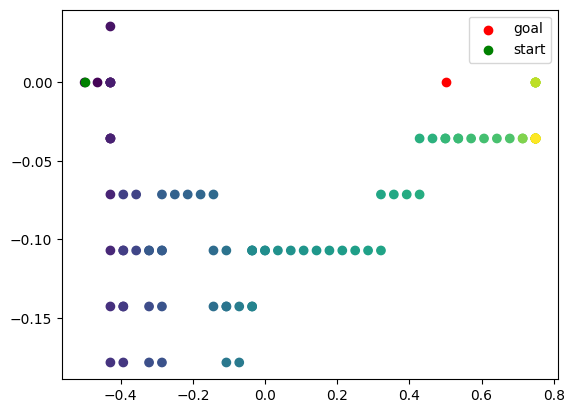

In [ ]:
#Plotting :D
x,y = X.detach().to('cpu').numpy(),Y.detach().to('cpu').numpy()
plt.scatter(x,y,c=np.arange(len(x)),cmap='viridis')
plt.scatter(0.5,0,c='r',label='goal')
plt.scatter(-0.5,0,c='g',label='start')
plt.legend()
plt.show()